
The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.



In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [12]:
df_housing = pd.read_csv('../data/housing.csv')
df_housing = df_housing.loc[df_housing['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df_housing['median_house_value'] = np.log(df_housing['median_house_value'])

In [14]:
df_train_val, df_test = train_test_split(df_housing, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

In [47]:
X_train = df_train.drop(columns=["median_house_value"])
y_train = df_train["median_house_value"]
X_val = df_val.drop(columns=["median_house_value"])
y_val = df_val["median_house_value"]
X_test = df_test.drop(columns=["median_house_value"])
y_test = df_test["median_house_value"]
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train.to_dict(orient="records"))
X_val = dv.transform(X_val.to_dict(orient="records"))
X_test = dv.transform(X_test.to_dict(orient="records"))

print(X_train.shape, X_val.shape, X_test.shape)

(9411, 10) (3138, 10) (3138, 10)


## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`



In [48]:
from sklearn.tree import DecisionTreeRegressor, export_text

In [49]:
def train_model(model, X, y, kwargs={}):
    model = model(**kwargs)
    model.fit(X, y)
    return model

def predict(model, X):
    return model.predict(X)


In [50]:
model = train_model(DecisionTreeRegressor, X_train, y_train, {'max_depth':1})
print(export_text(model, feature_names=dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.30]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845


In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
model = train_model(
    RandomForestRegressor,
    X_train,
    y_train,
    {"n_estimators": 10, "random_state": 1, "n_jobs": -1},
)

In [53]:
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [58]:
y_pred = predict(model, X_val)
print(round(rmse(y_val, y_pred), 3))

0.245


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160


In [59]:
for i in range(10, 200, 10):
    model = train_model(
        RandomForestRegressor,
        X_train,
        y_train,
        {"n_estimators": i, "random_state": 1, "n_jobs": -1},
    )
    y_pred = predict(model, X_val)
    print(i, round(rmse(y_val, y_pred), 3))

10 0.245
20 0.239
30 0.237
40 0.235
50 0.235
60 0.235
70 0.235
80 0.235
90 0.234
100 0.234
110 0.234
120 0.234
130 0.234
140 0.234
150 0.234
160 0.233
170 0.233
180 0.234
190 0.234


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25


In [60]:
for i in [10, 15, 20, 25]:
    model = train_model(
        RandomForestRegressor,
        X_train,
        y_train,
        {"n_estimators": 100, "max_depth": i, "random_state": 1, "n_jobs": -1},
    )
    y_pred = predict(model, X_val)
    print(i, round(rmse(y_val, y_pred), 3))

10 0.245
15 0.235
20 0.234
25 0.234


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`


In [65]:
model = train_model(
    RandomForestRegressor,
    X_train,
    y_train,
    {"n_estimators": 10, "max_depth": 20, "random_state": 1, "n_jobs": -1}
)

for i in range(len(model.feature_importances_)):
    print(dv.feature_names_[i], round(model.feature_importances_[i], 4))

households 0.0146
housing_median_age 0.0303
latitude 0.1015
longitude 0.0871
median_income 0.3357
ocean_proximity=<1H OCEAN 0.0353
ocean_proximity=INLAND 0.331
population 0.0283
total_bedrooms 0.0152
total_rooms 0.021


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```


Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [71]:
import xgboost as xgb

In [77]:
dv.get_feature_names_out().tolist()

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [84]:
features = dv.get_feature_names_out().tolist()
features = [name.replace('[', '_').replace(']', '_').replace('<', '_') for name in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

In [85]:
from matplotlib import pyplot as plt

[0]	train-rmse:0.44351	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463


[10]	train-rmse:0.21445	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24523
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23571
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23319
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225
[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13260	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11504	val-rmse:0.22877
[95]	train-rmse:0.11266	val-rmse:0.22865
[99]	train-rmse:0.11043	val-rmse:0.22873


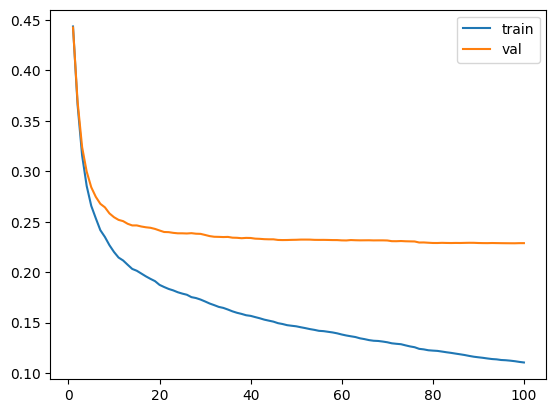

In [87]:
evals_result = {}
watchlist = [(dtrain, "train"), (dval, "val")]

model = xgb.train(params=xgb_params,
                  dtrain=dtrain,
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist,
                  evals_result=evals_result)

columns = ['iter', 'train_auc', 'val_auc']
train_aucs = list(evals_result['train'].values())[0]
val_aucs = list(evals_result['val'].values())[0]

df_scores = pd.DataFrame(
    list(zip(
        range(1, len(train_aucs) + 1),
        train_aucs,
        val_aucs
    )), columns=columns)

plt.plot(df_scores.iter, df_scores.train_auc, label='train')
plt.plot(df_scores.iter, df_scores.val_auc, label='val')
plt.legend()


In [88]:
xgb_params = {
    "eta": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

[0]	train-rmse:0.27425	val-rmse:0.29308
[5]	train-rmse:0.21451	val-rmse:0.26970
[10]	train-rmse:0.18924	val-rmse:0.26876
[15]	train-rmse:0.17171	val-rmse:0.27084
[20]	train-rmse:0.15683	val-rmse:0.27241
[25]	train-rmse:0.14548	val-rmse:0.27493
[30]	train-rmse:0.13446	val-rmse:0.27624
[35]	train-rmse:0.12711	val-rmse:0.27897
[40]	train-rmse:0.12065	val-rmse:0.28045
[45]	train-rmse:0.11316	val-rmse:0.28177
[50]	train-rmse:0.10692	val-rmse:0.28341
[55]	train-rmse:0.10019	val-rmse:0.28421
[60]	train-rmse:0.09445	val-rmse:0.28524
[65]	train-rmse:0.08992	val-rmse:0.28536
[70]	train-rmse:0.08385	val-rmse:0.28647
[75]	train-rmse:0.07793	val-rmse:0.28678
[80]	train-rmse:0.07384	val-rmse:0.28722
[85]	train-rmse:0.06930	val-rmse:0.28768
[90]	train-rmse:0.06557	val-rmse:0.28821
[95]	train-rmse:0.06160	val-rmse:0.28854
[99]	train-rmse:0.05884	val-rmse:0.28894


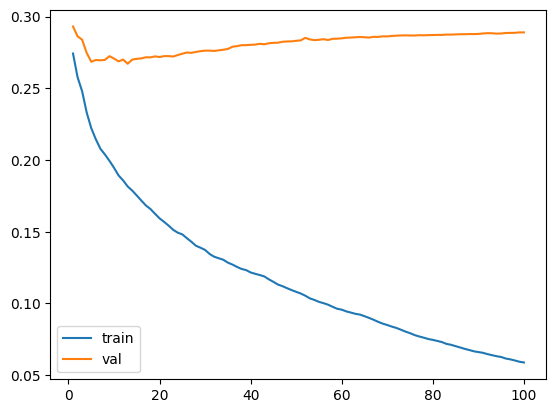

In [89]:
evals_result = {}
watchlist = [(dtrain, "train"), (dval, "val")]

model = xgb.train(params=xgb_params,
                  dtrain=dtrain,
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist,
                  evals_result=evals_result)

columns = ['iter', 'train_auc', 'val_auc']
train_aucs = list(evals_result['train'].values())[0]
val_aucs = list(evals_result['val'].values())[0]

df_scores = pd.DataFrame(
    list(zip(
        range(1, len(train_aucs) + 1),
        train_aucs,
        val_aucs
    )), columns=columns)

plt.plot(df_scores.iter, df_scores.train_auc, label='train')
plt.plot(df_scores.iter, df_scores.val_auc, label='val')
plt.legend()



## Submit the results

- Submit your results here: https://forms.gle/Qa2SuzG7QGZNCaoV9
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 23 (Monday), 23:00 CET. After that the form will be closed.